
# Animal Condition Classification

Build an end-to-end machine learning workflow that predicts whether an animal's reported symptoms indicate a dangerous condition. The pipeline ingests the Kaggle "Animal Condition" dataset, explores class imbalance, engineers lightweight features, trains baseline models, and exports the best-performing classifier for downstream use.


In [36]:
import inspect
import json
import shutil
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODEL_DIR = Path("models")
REPORTS_DIR = Path("reports")

for folder in (RAW_DATA_DIR, PROCESSED_DATA_DIR, MODEL_DIR, REPORTS_DIR):
    folder.mkdir(parents=True, exist_ok=True)

DATASET_HANDLE = "gracehephzibahm/animal-disease"
RAW_DATASET_PATH = RAW_DATA_DIR / "animal_condition.csv"


def fetch_dataset(force_download: bool = False) -> Path:
    '''Download the Kaggle dataset via kagglehub and cache it locally.'''
    if RAW_DATASET_PATH.exists() and not force_download:
        print(f"Using cached dataset at {RAW_DATASET_PATH.resolve()}")
        return RAW_DATASET_PATH

    try:
        import kagglehub
    except ImportError as exc:  # pragma: no cover - informative failure only
        raise ModuleNotFoundError(
            "Install kagglehub with `pip install kagglehub` or download the CSV manually."
        ) from exc

    try:
        dataset_dir = Path(
            kagglehub.dataset_download(DATASET_HANDLE, force_download=force_download)
        )
        csv_candidates = sorted(dataset_dir.rglob("*.csv"))
        if not csv_candidates:
            raise FileNotFoundError(
                "No CSV files were found in the downloaded dataset directory."
            )
        shutil.copy2(csv_candidates[0], RAW_DATASET_PATH)
        print(f"Downloaded dataset to {RAW_DATASET_PATH.resolve()}")
    except Exception as exc:  # pragma: no cover - informative failure only
        raise RuntimeError(
            "Automatic download failed. Download `animal_condition.csv` from Kaggle "
            "and place it inside data/raw/ before re-running this cell."
        ) from exc

    return RAW_DATASET_PATH


raw_csv_path = fetch_dataset(force_download=False)
raw_csv_path

Using cached dataset at /Users/pierre/Projects/Animal condition/data/raw/animal_condition.csv


PosixPath('data/raw/animal_condition.csv')

In [ ]:
df_raw = pd.read_csv(raw_csv_path)
print(f"Rows: {df_raw.shape[0]:,} | Columns: {df_raw.shape[1]}")

df_raw.head()

Rows: 871 | Columns: 7


,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
0,Dog,Fever,Diarrhea,Vomiting,Weight loss,Dehydration,Yes
1,Dog,Fever,Diarrhea,Coughing,Tiredness,Pains,Yes
2,Dog,Fever,Diarrhea,Coughing,Vomiting,Anorexia,Yes
3,Dog,Fever,Difficulty breathing,Coughing,Lethargy,Sneezing,Yes
4,Dog,Fever,Diarrhea,Coughing,Lethargy,Blue Eye,Yes


In [ ]:
missing_summary = (
    pd.DataFrame({
        "missing": df_raw.isna().sum(),
        "unique": df_raw.nunique(),
    })
    .sort_values("missing", ascending=False)
)

print("Missing values and cardinality by column:")
missing_summary

Missing values and cardinality by column:


,missing,unique
Dangerous,2,2
AnimalName,0,46
symptoms1,0,232
symptoms2,0,230
symptoms3,0,229
symptoms4,0,217
symptoms5,0,203


In [ ]:
print("Target distribution (Dangerous column):")
df_raw.get("Dangerous", df_raw.get("Condition")).value_counts(dropna=False)

Target distribution (Dangerous column):


Dangerous
Yes    849
No      20
NaN      2
Name: count, dtype: int64

In [41]:
TARGET_COLUMN = "dangerous"

SYMPTOM_COLUMNS = [f"symptom_{i}" for i in range(1, 6)]
CATEGORICAL_FEATURES = ["animal_name", *SYMPTOM_COLUMNS]
NUMERIC_FEATURES = ["num_reported_symptoms"]
MODEL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

COLUMN_RENAME_MAP = {
    **{k: "animal_name" for k in ["AnimalName", "Animal", "Animal_name", "animal"]},
    **{k: f"symptom_{i}" for i in range(1, 6) for k in [f"Symptoms{i}", f"symptoms{i}", f"Symptom{i}"]},
    **{k: TARGET_COLUMN for k in ["Dangerous", "Condition"]},
}

FEATURE_RENAME_MAP = {k: v for k, v in COLUMN_RENAME_MAP.items() if v != TARGET_COLUMN}

TARGET_VALUE_MAP = {
    "dangerous": 1, "true": 1, "yes": 1, "1": 1,
    "not dangerous": 0, "false": 0, "no": 0, "0": 0,
}


def normalize_text_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.replace(r"\s+", " ", regex=True).str.lower()
    return s.replace({"": np.nan, "nan": np.nan, "none": np.nan})


def _rename(df: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    mapping = {k: v for k, v in mapping.items() if k in df.columns}
    return df.rename(columns=mapping)


def prepare_features_from_raw(data: pd.DataFrame) -> pd.DataFrame:
    df = _rename(data.copy(), FEATURE_RENAME_MAP)

    # ensure + normalize categoricals
    for col in CATEGORICAL_FEATURES:
        df[col] = normalize_text_series(df[col]) if col in df.columns else np.nan

    df["num_reported_symptoms"] = df[SYMPTOM_COLUMNS].notna().sum(axis=1)
    return df[MODEL_FEATURES]


def clean_dataset(data: pd.DataFrame) -> pd.DataFrame:
    df = _rename(data.copy(), COLUMN_RENAME_MAP)
    if TARGET_COLUMN not in df.columns:
        raise ValueError("Target column is missing from the dataset.")

    X = prepare_features_from_raw(df)

    y = normalize_text_series(df[TARGET_COLUMN]).map(TARGET_VALUE_MAP)
    y = y.fillna(y.mode(dropna=True).iloc[0]).astype(int)

    dataset = pd.concat([X, y.rename(TARGET_COLUMN)], axis=1)
    return (
        dataset
        .dropna(subset=CATEGORICAL_FEATURES, how="all")
        .drop_duplicates()
    )

In [ ]:
df_clean = clean_dataset(df_raw)
print(f"Clean rows: {df_clean.shape[0]:,}")
df_clean.head()

Clean rows: 841


,animal_name,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,num_reported_symptoms,dangerous
0,dog,fever,diarrhea,vomiting,weight loss,dehydration,5,1
1,dog,fever,diarrhea,coughing,tiredness,pains,5,1
2,dog,fever,diarrhea,coughing,vomiting,anorexia,5,1
3,dog,fever,difficulty breathing,coughing,lethargy,sneezing,5,1
4,dog,fever,diarrhea,coughing,lethargy,blue eye,5,1


In [43]:
X = df_clean[MODEL_FEATURES]
y = df_clean[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
)

print(f"Training rows: {X_train.shape[0]:,} | Test rows: {X_test.shape[0]:,}")

Training rows: 672 | Test rows: 169


In [44]:
one_hot_params = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    one_hot_params["sparse_output"] = False
else:  # pragma: no cover - backwards compatibility
    one_hot_params["sparse"] = False

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(**one_hot_params)),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, CATEGORICAL_FEATURES),
        ("numeric", numeric_transformer, NUMERIC_FEATURES),
    ]
)

In [45]:
models = {
    "log_reg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced_subsample",
    ),
}

scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
cv_rows = []
for name, estimator in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", estimator),
        ]
    )
    cv_result = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        error_score="raise",
    )
    cv_rows.append(
        {
            "model": name,
            **{metric: cv_result[f"test_{metric}"].mean() for metric in scoring},
            **{f"{metric}_std": cv_result[f"test_{metric}"].std() for metric in scoring},
        }
    )

cv_summary = pd.DataFrame(cv_rows).set_index("model")
cv_summary

,accuracy,precision,recall,f1,roc_auc,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std
model,,,,,,,,,,
log_reg,0.988093,0.993893,0.993905,0.993893,0.943785,0.013840,0.005744,0.0089,0.007104,0.100536
random_forest,0.979171,0.979126,1.000000,0.989445,0.946636,0.005538,0.005490,0.0000,0.002806,0.092692


In [46]:
log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
            ),
        ),
    ]
)

best_pipeline = log_reg_pipeline.fit(X_train, y_train)
best_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('categorical', ...), ('numeric', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tra

In [47]:
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

evaluation = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba),
}
pd.DataFrame([evaluation])

,accuracy,precision,recall,f1,roc_auc
0,1.0,1.0,1.0,1.0,1.0


               precision    recall  f1-score   support

Not Dangerous       1.00      1.00      1.00         4
    Dangerous       1.00      1.00      1.00       165

     accuracy                           1.00       169
    macro avg       1.00      1.00      1.00       169
 weighted avg       1.00      1.00      1.00       169



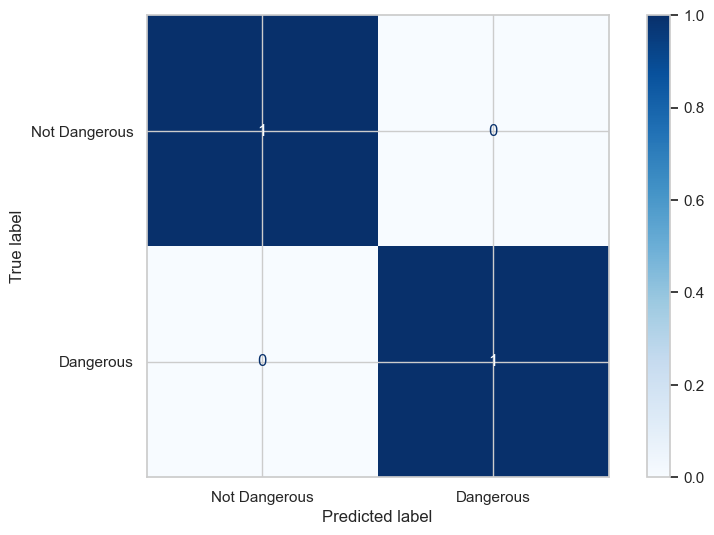

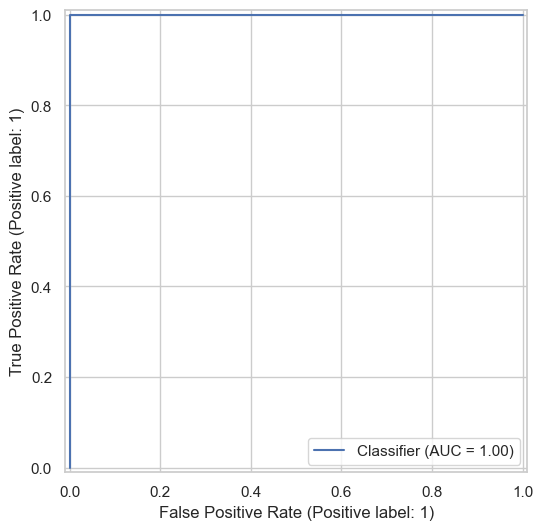

In [48]:
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Not Dangerous", "Dangerous"],
        zero_division=0,
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["Not Dangerous", "Dangerous"],
    normalize="true",
    cmap="Blues",
)
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

In [49]:
MODEL_PATH = MODEL_DIR / "animal_condition_log_reg.joblib"
METRICS_PATH = REPORTS_DIR / "log_reg_metrics.json"

joblib.dump(best_pipeline, MODEL_PATH)
with open(METRICS_PATH, "w", encoding="utf-8") as fp:
    json.dump(
        {
            "model_path": str(MODEL_PATH.resolve()),
            "metrics": evaluation,
            "test_samples": int(y_test.shape[0]),
            "features": MODEL_FEATURES,
        },
        fp,
        indent=2,
    )

MODEL_PATH, METRICS_PATH

(PosixPath('models/animal_condition_log_reg.joblib'),
 PosixPath('reports/log_reg_metrics.json'))

In [50]:
def predict_condition(payload: dict) -> dict:
    '''Helper function for inference on raw payloads.'''
    features = prepare_features_from_raw(pd.DataFrame([payload]))
    prediction = best_pipeline.predict(features)[0]
    probability = best_pipeline.predict_proba(features)[0, 1]
    return {
        "label": "Dangerous" if prediction == 1 else "Not Dangerous",
        "probability_dangerous": float(probability),
    }


sample_payload = {
    "AnimalName": "Buffalo",
    "Symptoms1": "Fever",
    "Symptoms2": "Diarrhea",
    "Symptoms3": "Weight loss",
    "Symptoms4": "Weakness",
    "Symptoms5": "Pain",
}

predict_condition(sample_payload)

{'label': 'Dangerous', 'probability_dangerous': 0.9757496162408327}